<a href="https://colab.research.google.com/github/vamsigaddipati9/Trahsformer/blob/main/Trashformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import requests
import json
from PIL import Image

# Set the API key
ARLIAI_API_KEY = "------------"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Image loaded successfully
Detected items:
bottle: 0.99
diningtable: 0.82


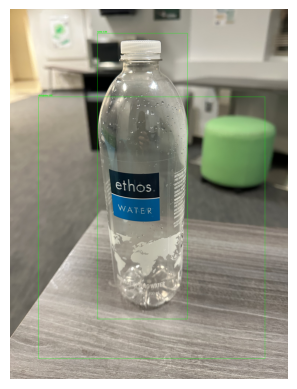

In [ ]:
# Load YOLO model and class labels
net = cv2.dnn.readNet(r"C:\Users\jrdns\Downloads\Trashformers\yolov3.weights", r"C:\Users\jrdns\Downloads\Trashformers\yolov3.cfg")
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Initialize lists to hold detected bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []

# Load an image
image = cv2.imread('/content/gdrive/My Drive/IMG_0041.jpg') # Image that is being uploaded
if image is None:
    print("Error: Image not found or unable to load")
else:
    print("Image loaded successfully")
    height, width = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get the output layer names
    output_layer_indices = net.getUnconnectedOutLayers()
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in output_layer_indices]

    # Run forward pass and get the detections
    outputs = net.forward(output_layers)

    # Loop over each detection
    for output in outputs:
        for detection in output:
            scores = detection[5:]  # The class probabilities start at index 5
            class_id = np.argmax(scores)  # The class with the highest confidence
            confidence = scores[class_id]

            # Filter out weak detections
            if confidence > 0.5:
                # YOLO outputs center (x, y) of bounding box, and width, height
                box = detection[:4] * np.array([width, height, width, height])
                center_x, center_y, box_w, box_h = box.astype("int")

                # Calculate the top-left corner of the bounding box
                x = int(center_x - (box_w / 2))
                y = int(center_y - (box_h / 2))

                # Append to lists
                boxes.append([x, y, int(box_w), int(box_h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    detected_items = []

    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            detected_items.append(f"{label}: {confidence:.2f}")
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Output the detected items
    if detected_items:
        print("Detected items:")
        for item in detected_items:
            print(item)
    else:
        print("No items detected.")

    # Show the image with the detections
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
# Initialize Output
output_text = ""

# Database of alternate uses
reusable_items = [
    {
        "name": "Plastic Bottle",
        "reuse_ideas": "Cut and use as planters, or make DIY storage containers.",
        "recycling_instructions": "Rinse and place in the recycling bin."
    },
    {
        "name": "Glass Jar",
        "reuse_ideas": "Reuse as storage jars for spices, screws, or craft supplies.",
        "recycling_instructions": "Rinse thoroughly, remove the lid, and recycle."
    },
    {
        "name": "Aluminum Can",
        "reuse_ideas": "Use for small planters, pen holders, or candle molds.",
        "recycling_instructions": "Rinse, crush if possible, and recycle."
    },
    {
        "name": "Cardboard Box",
        "reuse_ideas": "Cut and use for DIY drawer dividers or kids' craft projects.",
        "recycling_instructions": "Flatten and recycle in the paper recycling bin."
    },
    {
        "name": "Milk Carton",
        "reuse_ideas": "Use as small planters or bird feeders with some DIY cutting.",
        "recycling_instructions": "Rinse and recycle if facilities accept cartons."
    },
    {
        "name": "Plastic Cutlery",
        "reuse_ideas": "Clean and reuse for picnics or kids' craft projects.",
        "recycling_instructions": "Recycle if facilities accept it; otherwise, dispose of as waste."
    },
    {
        "name": "Toilet Paper Roll",
        "reuse_ideas": "Use for cord organizers, seed starters, or kids' crafts.",
        "recycling_instructions": "Recycle in the paper bin."
    },
    {
        "name": "Shoe Box",
        "reuse_ideas": "Reuse as storage for small items, cable organizers, or crafts.",
        "recycling_instructions": "Recycle in paper bin if clean and free of adhesives."
    },
    {
        "name": "Glass Bottle",
        "reuse_ideas": "Use as a vase, DIY lamp, or decorative centerpiece.",
        "recycling_instructions": "Rinse and recycle in glass bin."
    },
    {
        "name": "Paper",
        "reuse_ideas": "Use for origami, scrapbooking, or as wrapping paper.",
        "recycling_instructions": "Place in the paper recycling bin."
    },
    {
        "name": "Tin Can",
        "reuse_ideas": "Use as a pen holder, plant pot, or for DIY lanterns.",
        "recycling_instructions": "Rinse, remove the lid, and place in metal recycling."
    },
    {
        "name": "Old T-shirt",
        "reuse_ideas": "Turn into cleaning rags, reusable bags, or use for craft projects.",
        "recycling_instructions": "Donate if in good condition or recycle at textile centers."
    },
    {
        "name": "Egg Carton",
        "reuse_ideas": "Use as seed starters, paint trays, or for kids' crafts.",
        "recycling_instructions": "Recycle paper cartons in the paper bin, dispose of foam responsibly."
    },
    {
        "name": "Metal Hanger",
        "reuse_ideas": "Use to organize scarves, belts, or for craft wire projects.",
        "recycling_instructions": "Return to dry cleaners for reuse, or recycle as scrap metal."
    },
    {
        "name": "Newspaper",
        "reuse_ideas": "Use for packing material, garden mulch, or gift wrapping.",
        "recycling_instructions": "Recycle in paper bin or use in compost."
    },
    {
        "name": "Cereal Box",
        "reuse_ideas": "Use for drawer organizers, or cut into bookmarks or postcards.",
        "recycling_instructions": "Flatten and place in the paper recycling bin."
    },
    {
        "name": "Old Magazines",
        "reuse_ideas": "Use for collages, vision boards, or wrapping gifts.",
        "recycling_instructions": "Recycle in paper bin."
    },
    {
        "name": "Bubble Wrap",
        "reuse_ideas": "Reuse for packaging, or as insulation material for plants in winter.",
        "recycling_instructions": "Recycle at plastic bag recycling points (often found at grocery stores)."
    },
    {
        "name": "Batteries",
        "reuse_ideas": "Rechargeable batteries can be reused multiple times.",
        "recycling_instructions": "Dispose of at designated battery recycling centers or e-waste facilities."
    },
    {
        "name": "Electronics (e.g., old phones, laptops)",
        "reuse_ideas": "Repurpose as media storage devices or donate for reuse.",
        "recycling_instructions": "Recycle at e-waste centers or return to manufacturers with recycling programs."
    },
    {
        "name": "Light Bulbs (CFLs or LEDs)",
        "reuse_ideas": "Some light bulbs can be repurposed for craft projects like ornaments or plant holders.",
        "recycling_instructions": "Recycle at designated recycling points (especially for CFLs due to mercury content)."
    },
    {
        "name": "Printer Cartridges",
        "reuse_ideas": "Refill and reuse at designated refill stations.",
        "recycling_instructions": "Recycle through manufacturer take-back programs or e-waste facilities."
    },
    {
        "name": "Old CDs/DVDs",
        "reuse_ideas": "Use for DIY crafts like coasters or wall art.",
        "recycling_instructions": "Recycle at specialized electronic recycling centers."
    },
    {
        "name": "Styrofoam (Polystyrene)",
        "reuse_ideas": "Use as insulation material for DIY projects or packaging.",
        "recycling_instructions": "Check with local recycling centers, as many do not accept styrofoam."
    },
    {
        "name": "Plastic Bags",
        "reuse_ideas": "Reuse for storage or packing, or as trash bin liners.",
        "recycling_instructions": "Recycle at designated plastic bag recycling points (often found at grocery stores)."
    },
    {
        "name": "Old Tires",
        "reuse_ideas": "Repurpose for DIY garden planters, playground equipment, or tire swings.",
        "recycling_instructions": "Recycle at tire recycling facilities or return to tire retailers for disposal."
    },
    {
        "name": "Fabric Scraps",
        "reuse_ideas": "Use for quilting, crafts, or stuffing pillows.",
        "recycling_instructions": "Donate to textile recycling centers or creative reuse centers."
    },
    {
        "name": "Plastic Food Containers",
        "reuse_ideas": "Reuse for food storage or DIY organizers.",
        "recycling_instructions": "Clean and recycle if facilities accept the type of plastic (usually #1 or #2)."
    },
    {
        "name": "Clothing (worn or damaged)",
        "reuse_ideas": "Repurpose into cleaning rags, patchwork, or insulation materials.",
        "recycling_instructions": "Donate if usable, or recycle at textile recycling centers."
    },
]

# Function to get recycling suggestion from ARLIAI API
def get_recycling_suggestion(item_name):
    url = "https://api.arliai.com/v1/chat/completions"

    payload = json.dumps({
        "model": "Meta-Llama-3.1-8B-Instruct",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Give a one-sentence recycling instruction for a {item_name} and also provide a one-sentence reusing instruction. Put these into separate sentences. Limit each sentence to 20 words at most."}
        ],
        "repetition_penalty": 1.1,
        "temperature": 0.7,
        "top_p": 0.9,
        "top_k": 40,
        "max_tokens": 1024,
        "stream": False

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Bearer {ARLIAI_API_KEY}"
    }
    response = requests.post(url, headers=headers, data=payload)

    # Check for a successful response
    if response.status_code == 200:
        # Parse the response and extract the assistant's reply
        response_data = response.json()
        suggestion = response_data['choices'][0]['message']['content']
        return suggestion.strip()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return "Could not get recycling instructions."
detected_items = ["bag"]
# Clean the confidence score from the detected object
cleaned_item = detected_items[0].split(':')[0].strip()

# Loop through each item in the reusable_items list
for item in reusable_items:
    if cleaned_item.lower() in item["name"].lower():
        output_text += f"Item: {item['name']}\n"
        output_text += f"Reuse Ideas: {item['reuse_ideas']}\n"
        output_text += f"Recycling Instructions: {item['recycling_instructions']}\n"
        break
else:
    # Search for results with AI
    suggestion = get_recycling_suggestion(item_name)
    output_text += f"Detected item: {item_name} (AI Response)\n"
    output_text += suggestion + "\n"

print(output_text)
# Export the results to a .txt file
with open(r"C:\Users\jrdns\Downloads\Trashformers\Output.txt", "w") as file:
    file.write(output_text)


Item: Plastic Bags
Reuse Ideas: Reuse for storage or packing, or as trash bin liners.
Recycling Instructions: Recycle at designated plastic bag recycling points (often found at grocery stores).

